In [179]:
# Initialize Otter
import otter
grader = otter.Notebook("project.ipynb")

# Project 2 – Loan Applications 💸

## DSC 80, Spring 2024

### Checkpoint Due Date (Questions 1 and 2): Friday, April 26th
### Due Date: Friday, May 3rd

## Instructions

---

### Working on the Project

This Jupyter Notebook contains the statements of the problems and provides code and Markdown cells to display your answers to the problems.

* Like the lab, your coding work will be developed in the accompanying `project.py` file, that will be imported into the current notebook. This code will be autograded.
    * We may manually grade part of your answer to Question 4 (`argument_for_nmar`), but the rest will be fully autograded, and all you will need to submit is `project.py`.
* **For the Checkpoint, which is required, you only need to turn in a `project.py` containing solutions for Questions 1 and 2!**
    - The "Project 2 Checkpoint" autograder on Gradescope does not thoroughly check your code – it only runs the public tests on Questions 1 and 2 to make sure that you have completed them. There are no hidden tests for the checkpoint, and you will see your score upon submission. 
    - When you submit the final version of the project, however, we will use hidden tests to check your answers more thoroughly.
    - Note that this means you will ultimately have to submit the project twice – once to the "Project 2 Checkpoint" autograder (Questions 1 and 2 only), and once to the "Project 2" autograder (once you're fully done).
- **Do not change the function names in `project.py` file!** The functions in `project.py` are how your assignment is graded, and they are graded by their name. If you changed something you weren't supposed to, you can find the original code in the [course GitHub repository](https://github.com/dsc-courses/dsc80-2024-sp).
- **To ensure that all of your work to be submitted is in `project.py`, we've included a script named `project-validation.py` in the project folder. You shouldn't edit it, but instead, you should call it from the command line (e.g. the Terminal) to test your work.** More details on its usage are given at the bottom of this notebook.
- You are encouraged to write your own additional helper functions to solve the project, as long as they also end up in `project.py`.

### Warning! 🚨

Many questions in the project intentionally build off of each other and the final result matters! In fact, you can "get a question correct," but only receive partial credit for it because a previous answer was wrong.

For any questions that related with number rounding, please be aware that `np.round()` and `round()` function differently. For this assignment, use `round()` when needed as it is the function we will utilize in the tests.

### Working with a Partner 👯

You may work together on projects (and projects only!) with a partner. If you work with a partner, you are both required to actively contribute to all parts of the project. You must both be working on the assignment at the same time together, either physically or virtually on a Zoom call. You are encouraged to follow the pair programming model, in which you work on just a single computer and alternate who writes the code and who thinks about the problems at a high level.

In particular, you **cannot** split up the project and each work on separate parts independently.

Note that if you do work with a partner, you and your partner must submit the Checkpoint together and the whole project together. See [here](https://dsc80.com/syllabus/#projects) for more details.

In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pd.options.plotting.backend = 'plotly'

from IPython.display import display

# DSC 80 preferred styles
pio.templates["dsc80"] = go.layout.Template(
    layout=dict(
        margin=dict(l=30, r=30, t=30, b=30),
        autosize=True,
        width=600,
        height=400,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+dsc80"

import plotly.figure_factory as ff
def create_kde_plotly(df, group_col, group1, group2, vals_col, title=''):
    fig = ff.create_distplot(
        hist_data=[df.loc[df[group_col] == group1, vals_col], df.loc[df[group_col] == group2, vals_col]],
        group_labels=[group1, group2],
        show_rug=False, show_hist=False
    )
    return fig.update_layout(title=title)

In [182]:
# Pandas Tutor setup
%reload_ext pandas_tutor
%set_pandas_tutor_options {"maxDisplayCols": 8, "nohover": True, "projectorMode": True}

In [183]:
from project import *

## About the Assignment 🧐

[LendingClub](https://www.lendingclub.com/) is a platform that allows individuals to borrow money – that is, take on **loans**. They've made available a massive dataset with information on millions of loans they've processed. The entire dataset is over 300 MB large, and so we won't work with it here – instead, we'll work with a sample from it.

Run the cell below to load in this sample from the file `data/loans.csv`.

In [184]:
loans_path = Path('data') / 'loans.csv'
loans = pd.read_csv(loans_path)
loans.head()

,id,loan_amnt,issue_d,term,int_rate,grade,sub_grade,emp_title,verification_status,home_ownership,annual_inc,loan_status,purpose,desc,addr_state,dti,fico_range_low,fico_range_high,hardship_flag,mths_since_last_delinq
0,17965023,18000.0,Jun-2014,60 months,16.99,D,D3,sales,Source Verified,RENT,60000.0,Charged Off,debt_consolidation,NaN,MN,23.22,700.0,704.0,N,72.0
1,111414087,10000.0,Jun-2017,36 months,16.02,C,C5,mechanic,Source Verified,OWN,50000.0,Current,home_improvement,NaN,IL,6.14,680.0,684.0,N,6.0
2,95219557,12800.0,Dec-2016,36 months,7.99,A,A5,general manager,Not Verified,MORTGAGE,47500.0,Fully Paid,debt_consolidation,NaN,MO,12.89,705.0,709.0,N,66.0
3,142831837,16000.0,Oct-2018,60 months,23.40,E,E1,nurse,Source Verified,MORTGAGE,120000.0,Current,home_improvement,NaN,FL,5.66,670.0,674.0,N,NaN
4,140113255,40000.0,Sep-2018,60 months,7.84,A,A4,staff pharmacist,Verified,MORTGAGE,150000.0,Current,debt_consolidation,NaN,MN,12.24,735.0,739.0,N,NaN


Each row of the dataset corresponds to a different loan that the LendingClub approved and paid out. Some of the key columns are:
- `'loan_amnt' (float)`: the amount of the loan, or how much the borrower borrowed.
- `'issue_d' (str)`: the date on which the loan was issued.
- `'term' (str)`: the length of the loan, that is, the amount of time the borrower has to pay the loan back.
- `'int_rate' (float)`: the interest rate the borrower will pay on their loan amount.

First, it's worth exploring the distribution of loan amounts. You'll see that the largest possible loan given out through LendingClub was \\$40,000.

In [185]:
loans['loan_amnt'].describe()

count     6300.000000
mean     15568.801587
std       7398.968439
min       1000.000000
25%      10400.000000
50%      15000.000000
75%      19125.000000
max      40000.000000
Name: loan_amnt, dtype: float64

Note that when a borrower is approved for a loan, they are presented with multiple offers with different loan terms and interest rates. **Larger interest rates make the loan more expensive for the borrower – as a borrower, you want a lower interest rate!** You'll note that even for the same loan amount, different borrowers were approved for different terms and interest rates. Take a look below:

In [186]:
loans.loc[loans['loan_amnt'] == 3600, ['loan_amnt', 'term', 'int_rate']]

,loan_amnt,term,int_rate
249,3600.0,36 months,24.50
626,3600.0,36 months,13.99
1020,3600.0,36 months,11.49
2141,3600.0,36 months,10.08
2145,3600.0,36 months,5.32
2584,3600.0,36 months,16.29
2739,3600.0,36 months,8.24
3845,3600.0,36 months,13.66
4153,3600.0,36 months,12.59
4368,3600.0,36 months,14.08


So, why do different borrowers receive different terms and interest rates, despite asking for the same amount of money? The factors that influence loan offers are complex, but it's [known](https://www.bankofamerica.com/smallbusiness/resources/post/factors-that-impact-loan-decisions-and-how-to-increase-your-approval-odds/) that some of the key factors are employment status, annual income, and credit score, among other things.

In this project, we will **explore how various borrower characteristics are related to one another**, in an attempt to better understand the complexity behind loans. It's important to remember, though, that this dataset only contains information about actually approved loans, **not** all loan applications.

---

<a name='outline'></a>

### Navigating the Project 🗺

Click on the links below to navigate to different parts of the project. 


- [Part 1: Understanding Lender Decision-Making 🤔](#part1)
    - [✅ Question 1 (Checkpoint Question)](#Question-1)
    - [✅ Question 2 (Checkpoint Question)](#Question-2)
    - [Question 3](#Question-3)
    - [Question 4](#Question-4)
- [Part 2: Calculating Disposable Incomes 💰](#part2)
    - [Question 5](#Question-5)
    - [Question 6](#Question-6)
    - [Question 7](#Question-7)
    - [Question 8](#Question-8)
- [Part 3: Identifying Simpson's Paradox 🙃](#part3)
    - [Question 9](#Question-9)
    - [Question 10](#Question-10)
    
---

<a name='part1'></a>

## Part 1: Understanding Lender Decision-Making 🤔

([return to the outline](#outline))

As mentioned above, the dataset we have only has information about approved loans – we don't have information about individuals who applied for loans and weren't approved. That means that we can't directly study what distinguishes successful loan applications from unsuccessful ones.

We'll start by understanding the **quantitative risks** that lenders assess when deciding what terms and interest rates to give to borrowers. Lenders typically charge higher interest rates to borrowers they perceive as high-risk. This practice serves several purposes: it offsets potential losses from unpaid debts, discourages excessively risky lending, and ensures that the higher returns from these loans can cover defaults. 

The first quantitative metric we'll look at is **debt-to-income (DTI) ratio**. Understanding the impact of such a metric on interest rates helps us in evaluating how lenders quantify risk.

<!-- The realm of lender decision-making is complex and multifaceted, influenced by a blend of traditional and non-traditional metrics. Our motivation is to delve into this domain and comprehend financial indicators, starting with: 
 -->
 
<!-- **Quantitative Risks:** Traditional metrics like **Debt-to-Income (DTI)** ratio and annual income are quantifiable and offer a concrete basis for assessing a borrower's financial health. 
 -->
<br/>

$$
\text{DTI} = \left( \frac{\text{Total Monthly Debt Payments}}{\text{Gross Monthly Income}} \right) \cdot 100 
$$

<br/>

Note that you don't need to calculate DTIs – they are already provided for us in the `'dti'` column of `loans`.


A low DTI indicates that a borrower is less likely to face financial strain from taking on additional debt, making them a lower risk to lenders. Conversely, a high DTI may signal financial overextension, suggesting a higher risk for default – that is, a higher risk that the borrower won't pay back the loan. 

When a lender perceives a higher risk of default, they often charge a higher interest rate. Let's see if this correlation is present in our dataset by looking a scatter plot of interest rate (`'int_rate'`) vs DTI (`'dti'`).

In [187]:
# Note: If the plot below doesn't appear, uncomment and run the following line.
# It will make all plotly plots render in a new browser tab.
# This is more inconvenient, but should bypass any rendering issues.

# pio.renderers.default = 'browser'

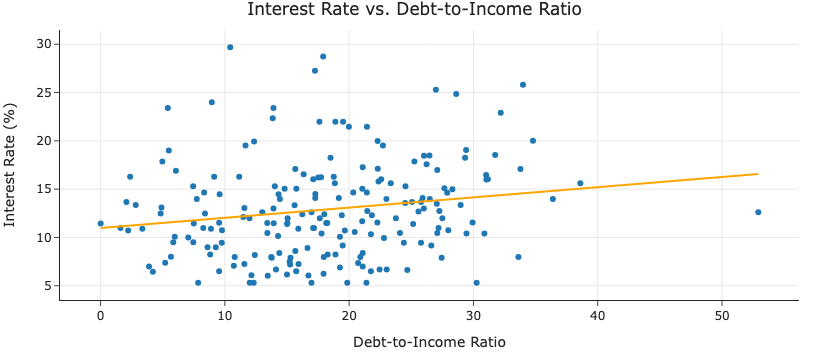

In [188]:
sample_set = loans.sample(200, random_state=1)

fig = px.scatter(sample_set, x='dti', y='int_rate', trendline='ols',
                 labels={'dti': 'Debt-to-Income Ratio', 'int_rate': 'Interest Rate (%)'},
                 trendline_color_override='orange',
                 title='Interest Rate vs. Debt-to-Income Ratio')

fig.show()

Indeed, it is!

### ✅ Question 1 (Checkpoint Question)

<a name='Question-1'></a>

([return to the outline](#outline))

We'll work with DTIs shortly, but first, we need to clean the dataset. Complete the implementation of the function `clean_loans`, which takes in a DataFrame like `loans` and returns a new DataFrame where:

- The `'issue_d'` column contains `pd.Timestamp` objects rather than strings.
- The `'term'` column contains ints rather than strings.
- The `'emp_title'` column is cleaned such that:
    - All employment titles are lowercase.
    - Leading and trailing whitespaces are removed.
    - The `'rn'` title is replaced with `'registered nurse'`. Note that there are other titles that include `'rn'` as part of a larger string, like `'clinical rn'` or `'attorney'`; for simplicity, **don't** replace `'rn'` in these titles with `'registered nurse'`. Instead, only replace titles that are exactly `'rn'` with `'registered nurse'`. (This means that you shouldn't use `.str.replace` to do your replacement here!)  
- There is a new column, `'term_end'`, which contains the date (as a `pd.Timestamp` object) on which each loan is fully paid.
    - ***Hint***: Use `pd.DateOffset`.

If you do the cleaning correctly, the three most common employment titles and frequencies in `loans` should be:

```py
teacher                 415
registered nurse        319
nurse                   112
```

In [189]:
def clean_title(x):
    return x.lower().strip()

# helper for part 4
def offset(x):
    from pandas.tseries.offsets import DateOffset
    return DateOffset(months = x)

def clean_loans(loans):
    copy = loans.copy(deep=True)
    copy['issue_d'] = copy['issue_d'].apply(lambda x: pd.Timestamp(x))
    copy['term'] = copy['term'].apply(lambda x: x.strip().split(' ', 1)[0])
    copy['term'] = copy['term'].apply(lambda x: int(x))

    copy['emp_title'] = copy['emp_title'].apply(clean_title)
    copy.head()
    copy.loc[copy['emp_title'] == 'rn', 'emp_title'] = 'registered nurse'
    
    offsets = copy['term'].apply(offset)
    copy['term_end'] = copy['issue_d'] + offsets
    
    return copy

Run the cell below to call `clean_data` on `loans`. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

In [190]:
loans = pd.read_csv(loans_path)
loans = clean_loans(loans)
loans.head()

,id,loan_amnt,issue_d,term,int_rate,grade,sub_grade,emp_title,verification_status,home_ownership,...,loan_status,purpose,desc,addr_state,dti,fico_range_low,fico_range_high,hardship_flag,mths_since_last_delinq,term_end
0,17965023,18000.0,2014-06-01,60,16.99,D,D3,sales,Source Verified,RENT,...,Charged Off,debt_consolidation,NaN,MN,23.22,700.0,704.0,N,72.0,2019-06-01
1,111414087,10000.0,2017-06-01,36,16.02,C,C5,mechanic,Source Verified,OWN,...,Current,home_improvement,NaN,IL,6.14,680.0,684.0,N,6.0,2020-06-01
2,95219557,12800.0,2016-12-01,36,7.99,A,A5,general manager,Not Verified,MORTGAGE,...,Fully Paid,debt_consolidation,NaN,MO,12.89,705.0,709.0,N,66.0,2019-12-01
3,142831837,16000.0,2018-10-01,60,23.40,E,E1,nurse,Source Verified,MORTGAGE,...,Current,home_improvement,NaN,FL,5.66,670.0,674.0,N,NaN,2023-10-01
4,140113255,40000.0,2018-09-01,60,7.84,A,A4,staff pharmacist,Verified,MORTGAGE,...,Current,debt_consolidation,NaN,MN,12.24,735.0,739.0,N,NaN,2023-09-01


In [191]:
grader.check("q1")

q1 results: All test cases passed!

Now that we've cleaned `loans`, we can easily do things like plot the number of loans per year in `loans`:

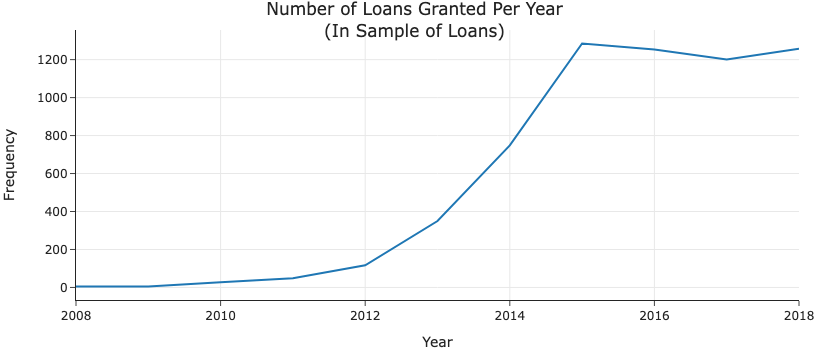

In [192]:
(
    loans['issue_d'].dt.year
    .value_counts()
    .sort_index()
    .plot(kind='line', 
          labels={'index': 'Year', 'value': 'Frequency'},
          title='Number of Loans Granted Per Year<br>(In Sample of Loans)')
    .update_layout(showlegend=False)
)

### ✅ Question 2 (Checkpoint Question)

<a name='Question-2'></a>

([return to the outline](#outline))

As mentioned at the start of Part 1, lenders give higher interest rates to borrowers they perceive as high-risk. In this question, we'll measure the **correlation** between interest rate (`'int_rate'`) and various other quantitative features: debt-to-income ratio (`'dti'`), annual income (`'annual_inc'`), credit score (`'fico_range_low'`), as well as loan length (`'term'`).

We've discussed debt-to-income ratios already, and annual incomes and loan lengths are easy to interpret, but credit scores might be new to you. The general idea behind credit scores is simple: the higher a borrower's credit score is, the more "trustworthy" they appear to lenders. FICO, short for the Fair Isaac Corporation, is a private organization that computes credit scores for lenders. FICO credit scores range from 300 (very poor) to 850 (excellent).

The DataFrame we have access to has two columns involving FICO scores: `'fico_range_low'` and `'fico_range_high'`. For almost all rows in `loans`, the value for `'fico_range_high'` is just 4 points higher than `'fico_range_low'`, so both columns essentially contain the same information:


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fico_range_low</th>
      <th>fico_range_high</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>700.0</td>
      <td>704.0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>680.0</td>
      <td>684.0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>705.0</td>
      <td>709.0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>670.0</td>
      <td>674.0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>735.0</td>
      <td>739.0</td>
    </tr>
  </tbody>
</table>
<center><i>The first few rows of <code>loans</code>.</i></center>

**So, for simplicity, "credit scores" and "FICO scores" will always refer to the values in the `'fico_range_low'` column for the rest of the project. Don't use `'fico_range_high'` for anything!** 

<br>

Back to the task at hand. To help us measure the correlation between interest rates and other quantitative features, complete the implementation of the function `correlations`, which takes in:
- a DataFrame, `df`, and
- a list, `pairs`, of **tuples**, each of which contains the names of two columns in `df`.

`correlations` should return a **Series** that has the same length as `pairs`, containing the correlation between each specified pair of columns. The values in the index of the Series should be strings of the form `'r_col1_col2'`, where `'col1'` and `'col2'` are the names of two columns, in the same order they appear in the input tuple.

Example behavior is given below.

```py
>>> correlations(loans, [
    ('dti', 'int_rate'),
    ('annual_inc', 'mths_since_last_delinq')
])

r_dti_int_rate                         ???
r_annual_inc_mths_since_last_delinq    ???
dtype: float64
```

Of course, your Series will have values that are numbers, not ???.

The correlation you compute should be the Pearson correlation, which is the same correlation coefficient you learned about in DSC 10. (In DSC 10, we called the correlation coefficient $r$, hence the index naming scheme above.) You won't have to compute it manually, though – there are a variety of built-in `pandas` and `numpy` methods which compute it for you directly.

***Note***: Make sure to test your function on DataFrames other than `loans`!

In [193]:
def correlations(df, pairs):
    pearsons = []
    for tpl in pairs:
        tpl_df = df[list(tpl)]
        tpl_df = tpl_df.corr(method='pearson').iloc[0][1]
        pearsons.append(tpl_df)
    pearsons = pd.Series(pearsons)
    pearsons.index = new_idx(pairs)
    return pearsons

In [194]:
def new_idx(pairs):
    indices = []
    for i in range(len(pairs)):
        idx = 'r_' + pairs[i][0] + '_' + pairs[i][1]
        indices.append(idx)
    return indices

['r_a_b', 'r_c_d']

Run the cell below to call `correlations` on `loans`, to find the correlations between debt-to-income and interest rate, annual income and interest rate, and FICO credit score and interest rate. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

In [195]:
q2_correlations = correlations(loans, [
    ('dti', 'int_rate'),
    ('annual_inc', 'int_rate'),
    ('fico_range_low', 'int_rate'),
    ('term', 'int_rate')
])
q2_correlations

r_dti_int_rate               0.173465
r_annual_inc_int_rate       -0.013588
r_fico_range_low_int_rate   -0.418918
r_term_int_rate              0.383405
dtype: float64

In [196]:
grader.check("q2")

q2 results: All test cases passed!

Run the cell below to draw a bar chart of the three correlations you computed, stored in `q2_correlations`.

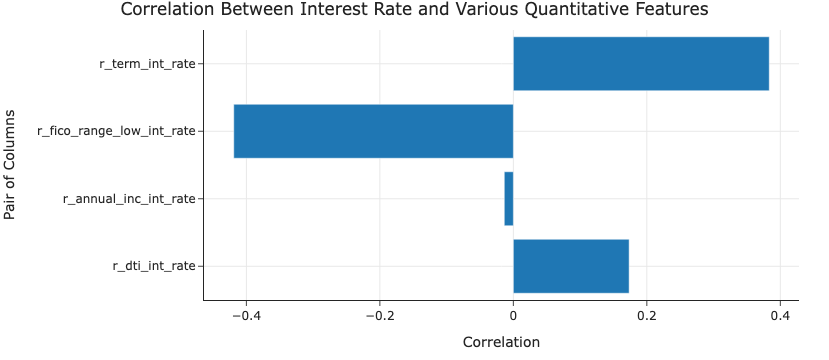

In [197]:
(
    q2_correlations
    .plot(kind='barh', 
          title='Correlation Between Interest Rate and Various Quantitative Features',
          labels={'index': 'Pair of Columns', 'value': 'Correlation'}
         )
    .update_layout(showlegend=False)
)

You should notice that of the four features analyzed, credit scores are most strongly correlated with interest rates, though term lengths also seem to be quite correlated. Let's first take a look at a scatter plot of interest rate vs. credit score.

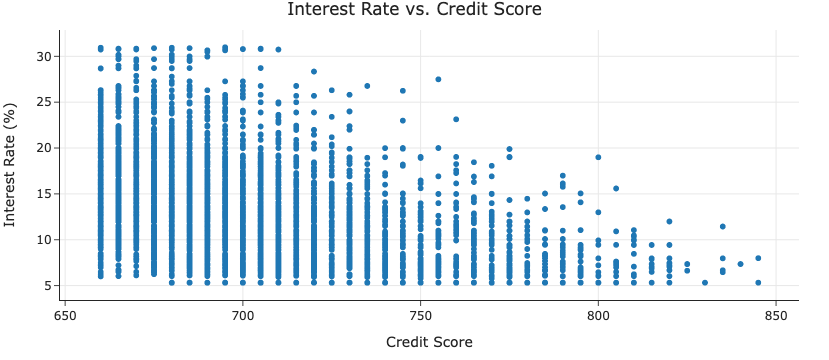

In [198]:
px.scatter(loans, x='fico_range_low', y='int_rate',
           labels={'fico_range_low': 'Credit Score', 'int_rate': 'Interest Rate (%)'},
           title='Interest Rate vs. Credit Score')

There's a lot of overplotting here, meaning that many points are being plotted on top of one another. It does indeed seem that as credit scores increase, interest rates tend to decrease on average, but perhaps there's a better way to visualize this information.


One idea is to place credit scores into categories by **binning** them. According to [Experian](https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/#s1), one of the three major credit bureaus in the US, FICO credit scores are described qualitatively as follows:

| Score | Category |
|---|---|
| 580 - 669 | Fair |
| 670 - 739 | Good |
| 740 - 799 | Very Good |
| 800 - 850 | Excellent |

There is actually also a bin below fair, named "poor" with a range of 300-579, but since `loans` doesn't have any poor credit scores, we'll exclude them from our exploration here. Note that while the `dtype` of `'fico_range_low'` is `float`, credit scores are actually integers.

Once we place credit scores into bins, we can visualize the distribution of interest rates separately for each credit score bin. Here, that would allow us to draw four separate distributions of interest rates – one for the fair group, one for the good group, one for the very good group, and one for the excellent group. Each one of those four distributions are **numerical distributions**, which we have several tools for visualizing; the most common tool you've seen is the histogram, but others exist, like the boxplot and violin plot. Let's explore this idea further!

### Question 3

([return to the outline](#outline))

Complete the implementation of the function `create_boxplot`, which takes in a DataFrame like `loans` and returns a `plotly` figure object containing a **boxplot describing the distribution of interest rates, separately for each of the four credit score bins mentioned above, and separately for the two loan lengths**. Here's an example of the plot you'll need to create:

<center><img src="imgs/example-q3.png" width=60%></center>

To create your figure, you'll use the `px.box` function and provide several arguments. This [`plotly` article](https://plotly.com/python/box-plots/) will be extremely helpful.

Before using `px.box`, though, you'll need to place credit scores into bins. There's a `pandas` function that will be helpful here. **Make sure the bins match those in our example plot exactly – inclusive of the left endpoint and exclusive of the right endpoint.** You'll need to hard-code these when creating your plot. You can assume that nobody has an exact credit score of 850. Once you've binned scores, you'll need to convert your Series of bin assignments to strings so that they can be used on the $x$-axis of a `px.box` figure.

Here are some additional requirements for you to get full credit on your boxplot:
- Make sure your axis labels, legend labels, and title are the same as ours.
- You **must** change the colors of the two terms from the default colors to something else. We chose purple and gold. To do this, you'll need to manually specify what color you want for the `36` group and the `60` group; it is fine to hard-code these two term lengths when creating your plot.

Lastly, remember that credit scores are stored in `'fico_range_low'`. 

In [199]:
import pandas as pd
import plotly.graph_objects as go

def create_boxplot(loans):
    df = loans.copy()
    # Define the credit score bins
    score_bins = [580, 670, 740, 800, 850]
    score_labels = ['[580, 670)', '[670, 740)', '[740, 800)', '[800, 850)']
    
    # Bin the credit scores
    df['credit_score_bin'] = pd.cut(df['fico_range_low'], bins=score_bins, labels=score_labels, right=False)
    
    # Convert the credit score bin to string
    df['credit_score_bin'] = df['credit_score_bin'].astype(str)

    #term_colors = {'36':'deeppink', '60':'deepskyblue'}
    
    # Create the boxplot
    fig = px.box(df, x='credit_score_bin', y='int_rate', color='term',
                 category_orders={'credit_score_bin': score_labels, 'term': ['36', '60']},
                 color_discrete_sequence=['deeppink', 'deepskyblue'], labels={'credit_score_bin': 'Credit Score Range', 'int_rate': 'Interest Rate (%)', 'term': 'Loan Length (Months)'},
                 title='Interest Rate vs. Credit Score')
    
    return fig

Run the cell below to draw your boxplot. If you did everything correctly, it should look like the example above. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

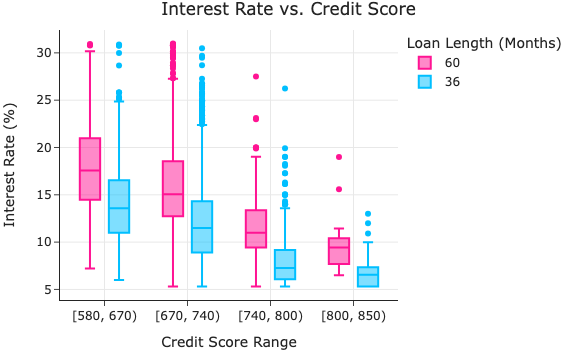

In [200]:
q3_fig = create_boxplot(loans)
q3_fig

In [201]:
grader.check("q3")

q3 results: All test cases passed!

If you created your boxplot correctly, you should have seen a few things:
- As borrowers' credit scores increase, both the median and variance in interest rates tend to decrease.
- Across the spectrum of credit scores, 60 month loans tend to have higher interest rates than 36 month loans.

You might wonder why longer loans have higher interest rates. From [The Motley Fool](https://www.fool.com/the-ascent/personal-loans/longer-repayment-terms-personal-loans-pros-cons/#:~:text=A%20longer%20term%20is%20riskier,charge%20a%20higher%20interest%20rate.):

> A longer term is riskier for the lender because there's more of a chance interest rates will change dramatically during that time. There's also more of a chance something will go wrong and you won't pay the loan back. Because it's a riskier loan to make, lenders charge a higher interest rate.

Good to know!

Now that we've investigated the role of some of the quantitative factors behind interest rates, let's look at some of the more subjective factors. Take a look at the following personal statement, for example:

> i recently proposed to my girlfriend of almost 8 yrs now and everything was going well untill our pug (ody) the middle of my three dogs started limping around and stumbling all the time. well come to find out he has a tumor on his spine. not very good news for us as our dogs are pretty much our children. so the reason for my loan request is the money i spent on the engagement ring was most of my savings and then i had to take out paydayloans loans for the mylogram bill, wich is similar to an MRI. $2,700 along with meds, visits etc.

You suspect that, perhaps, loans that included personal statements in their applications were given higher interest rates than loans that didn't include personal statements in their applications. This is true in `loans`:

,count,mean,std,min,25%,50%,75%,max
has_ps,,,,,,,,
False,5976.0,13.093203,4.908906,5.31,9.4400,12.62,15.99,30.99
True,324.0,13.676389,4.027071,5.79,11.1325,13.68,16.29,24.89


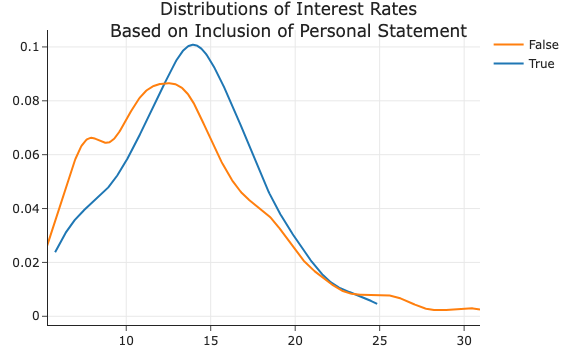

In [202]:
display(loans.assign(has_ps=loans['desc'].notna()).groupby('has_ps')['int_rate'].describe())
create_kde_plotly(
    loans.assign(has_ps=loans['desc'].notna()),
    'has_ps',
    True,
    False,
    'int_rate',
    title='Distributions of Interest Rates<br>Based on Inclusion of Personal Statement'
)

But remember, `loans` is just a sample from a much larger population of loan applications. Is this observed difference statistically significant? Let's perform a permutation test.

### Question 4

<a name='Question-4'></a> 

([return to the outline](#outline))

#### `ps_test`

Complete the implementation of the function `ps_test`, which takes in two arguments – a DataFrame like `loans` and a number `N` of repetitions – and returns the p-value for the following permutation test:

- **Null Hypothesis**: Interest rates given to applications with personal statements are the same, on average, as the interest rates given to applications without personal statements.
- **Alternative Hypothesis**: Interest rates given to applications with personal statements are larger on average than interest rates given to applications without personal statements.

As your test statistic, use the **difference in group means (with statement mean minus without statement mean)**.

<br>


#### `missingness_mechanism`

While not stated above explicitly, we can interpret our permutation test as one that assesses whether the missingness of a personal statement is dependent on interest rate.

Run your `ps_test` function with 5000 repetitions. Given the p-value you saw, what do you believe is the most likely missingness mechanism of the personal statement column, assuming we've narrowed down the missingness mechanism to these two options?

1. Missing completely at random (MCAR).
1. Missing at random (MAR) dependent on interest rate.

Complete the implementation of the function `missingness_mechanism`, which takes in no arguments and returns either 1 or 2, corresponding to your answer to the question above.

<br>

#### `argument_for_nmar`

In the function above, we had you use your permutation test to decide between MCAR and MAR as the likely missingness mechanism for personal statements. But, you could make an argument that personal statements are not missing at random (NMAR), too.

Complete the implementation of the function `argument_for_nmar`, which takes in no arguments and returns a **string** with a one-sentence justification as to why personal statements may be not missing at random.

***Note***: We may manually grade your answer to `argument_for_nmar` – passing the autograder tests for `argument_for_nmar` is not necessarily sufficient!

In [349]:
def ps_test(loans, N):
    df = loans.copy()
    # Filter data with and without personal statements
    with_ps = df[df['has_personal_statement'] == 1]['int_rate']
    without_ps = df[df['has_personal_statement'] == 0]['int_rate']
    
    # Compute observed test statistic (difference in means)
    obs_diff = with_ps.mean() - without_ps.mean()
    
    # Concatenate the interest rates
    all_rates = np.concatenate([with_ps.values, without_ps.values])
    
    # Initialize array to store permutation test statistics
    perm_diffs = np.zeros(N)
    
    # Permutation test
    for i in range(N):
        # Permute the interest rates
        np.random.shuffle(all_rates)
        
        # Compute difference in means for permuted groups
        perm_with_ps = all_rates[:len(with_ps)]
        perm_without_ps = all_rates[len(with_ps):]
        perm_diffs[i] = perm_with_ps.mean() - perm_without_ps.mean()
    
    # Compute p-value
    p_value = (perm_diffs >= obs_diff).mean()
    
    return p_value

def diff_means(df, N):
    stats = []
    copy = df.copy(deep=True)
    for i in range(N):
        copy['desc'] = np.random.permutation(copy['desc'])
        y_statement = copy.loc[copy['desc'].isna() ==  False]['int_rate'].mean()
        n_statement = copy.loc[copy['desc'].isna() == True]['int_rate'].mean()
        t_stat = y_statement - n_statement
        stats.append(t_stat)
    return stats

def ps_test(loans, N):
    copy = loans.copy(deep=True)
    y_statement = copy.loc[copy['desc'].isna() ==  False]['int_rate'].mean()
    n_statement = copy.loc[copy['desc'].isna() == True]['int_rate'].mean()
    observed_diff = y_statement - n_statement
    t_stats = diff_means(copy, N)
    p_val = (np.array(np.abs((t_stats))) >= np.abs(observed_diff)).mean()
    return p_val

def missingness_mechanism():
    return 2

def argument_for_nmar():
    return '''
    The permutation test suggests that there is a statistically significant difference 
    between interest rates for borrowers with personal statements, versus borrowers without 
    personal statements, so we can reject the null hypothesis and assume that the data is MAR and dependent on interest rate.
    '''

In [351]:
grader.check("q4")

q4 results: All test cases passed!

<a name='part2'></a>

## Part 2: Calculating Disposable Incomes 💰

([return to the outline](#outline))

In Part 1, we focused on understanding how the interest rates LendingClub chose to give to borrowers depended on different aspects of a borrower's application. In Part 2, we'll focus on understanding borrowers' **disposable incomes**, or net incomes:

$$
\text{Disposable Income} = \text{Gross Income} - \text{Federal Income Tax} - \text{State Income Tax} 
$$

This is a minor simplification, because [some cities](https://www.stlouis-mo.gov/government/departments/comptroller/initiatives/us-cities-that-levy-earnings-taxes.cfm) also collect city-specific income taxes, but we'll ignore those here. Note that the `'annual_inc'` column in `loans` contains each borrower's gross income – that is, their income before taxes are removed.

Understanding a borrower's disposable income enables lenders to evaluate a borrower's ability to meet loan obligations, ensuring that the risk of failing to pay back the loan (or **defaulting**) is minimized. In other words, knowing a borrower's disposable income allows lenders to structure loan payments in a way that aligns with the borrower's cash flow, reducing the likelihood of missed payments.

The United States, like many countries, uses a progressive tax bracket system. This means that as your earnings increase, the percentage of your earnings you owe in tax also increases. In addition, the US tax system uses marginal tax brackets – what this means is that US taxpayers pay different tax percentages on different "chunks" of their earnings.

Here's how Part 2 is structured:
- In Question 5, you'll define a general purpose function that takes in a gross income and an arbitrary tax bracket and returns the amount of tax owed.
- In Questions 6 and 7, you'll clean a DataFrame that contains tax brackets for different states so that the brackets are in a format that you can use with your function from Question 5.
- And finally, in Question 8, you'll compute the amount of disposable income each borrower has.

Let's get started!

### Question 5

<a name='Question-5'></a>

([return to the outline](#outline))

Let's use the following example to illustrate how tax brackets work. You may have actually seen the same example in DSC 10, but for reasons you're about to see, your implementation will be a bit more complicated here.

| Tax Rate | Tax Bracket |
| --- | --- |
| 10% | [$0, \\$11,000] |
| 12% | (\\$11,000, \\$44,725] |
| 22% | (\\$44,725, \\$95,375] |
| 24% | (\\$95,375, \\$182,100] |
| 32% | (\\$182,100, \\$231,251] |
| 35% | (\\$231,251, \\$578,125] |
| 37% | Over \\$578,125        |


If someone has a gross, or **taxable**, income of \\$75,000, we say they are in the 22% tax bracket. However, such an individual doesn't owe 22% of \\$75,000 in taxes. Instead, they owe:
- 10% of \\$11,000, **plus**
- 12% of \\$33,725 (which is \\$44,725 - \\$11,000), **plus**
- 22% of \\$30,275 (which is \\$75,000 - \\$44,725).

More concretely, their tax owed is
$$0.1 \cdot \$11{,}000 + 0.12 \cdot \$33{,}725 + 0.22 \cdot \$30{,}275 = \$11,807.50.$$


<br>

For the purposes of this question, we will express tax brackets – like the one in the table above – using a **list of tuples**. For instance, we can express the tax brackets above as follows:

```py
[(0.1, 0), 
 (0.12, 11000), 
 (0.22, 44725), 
 (0.24, 95375), 
 (0.32, 182100),
 (0.35, 231251),
 (0.37, 578125)
]
```

Each tuple is structured as `(tax_rate, bracket_lower_limit)`. For example, `(0.1, 0)` indicates a 10% tax rate for income above \\$0.

Before implementing anything, make sure you deeply understand:
1. How we found that a gross income of \\$75,000 owes \\$11,807.50 in taxes using the brackets above.
1. How we've represented the brackets from the table above as a list of tuples.

<br>

Now, complete the implementation of the function `tax_owed`, which takes in a float, `income`, and a list of tuples, `brackets`, and returns the amount of tax owed on a gross income of `income`, using the provided `brackets` (formatted as in the example above).

Example behavior is given below.

```py
>>> tax_owed(75000, 
[(0.1, 0), 
 (0.12, 11000), 
 (0.22, 44725), 
 (0.24, 95375), 
 (0.32, 182100),
 (0.35, 231251),
 (0.37, 578125)
])
11807.5
```

**Make sure to test your function with brackets other than the one above, and verify that it works correctly by replicating the calculations by hand!**

In [266]:
def tax_owed(income, brackets):
    taxes = []
    for i in range(len(brackets)-1):
        taxable = brackets[i][0] * (brackets[i+1][1]-brackets[i][1])
        taxes.append(taxable)
    j=0
    while (income >= brackets[j][1]) & (j<=len(brackets)-2):
        j += 1
    tax = np.sum(taxes[0:j-1])
    tax += brackets[j-1][0] * (income-brackets[j-1][1])
    return tax

The cell below defines the same example brackets we provided in the example above. Feel free to use them in your testing, but remember to test your functions with other brackets. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

In [267]:
example_brackets = [
 (0.1, 0), 
 (0.12, 11000), 
 (0.22, 44725), 
 (0.24, 95375), 
 (0.32, 182100),
 (0.35, 231251),
 (0.37, 578125)]
example_owed = tax_owed(75000, example_brackets)
example_owed

11807.5

In [268]:
grader.check("q5")

q5 results: All test cases passed!

Now that we have a general-purpose function that can take in a gross income and a list of tax brackets and return the tax owed, we want to use this function to compute both the **state** and **federal** taxes each loan applicant owed.

To start this process, we'll load in a DataFrame that contains the tax brackets for each state in 2023 ([source](https://taxfoundation.org/data/all/state/state-income-tax-rates-2023/)). Not all of the loan applications were submitted in 2023 – in fact, they were all submitted between 2008 and 2018 – but brackets don't change very much from year to year, so for simplicity we'll use these brackets throughout.

Run the cell below to define a DataFrame named `state_taxes_raw` with the relevant information.

In [269]:
state_taxes_raw_path = Path('data') / 'state_taxes_raw.csv'
state_taxes_raw = pd.read_csv(state_taxes_raw_path)
state_taxes_raw.head()

,State,Rate,Lower Limit
0,Ala.,2.00%,$0
1,"(a, b, c)",4.00%,$500
2,NaN,5.00%,"$3,000"
3,NaN,NaN,NaN
4,Alaska,none,NaN


As you can see, the state of the DataFrame is a bit hard to parse. The information we need is in there, but you'll need to clean 🧹 it up so that it's in the right format.

**Before proceeding, you may want to open `data/state_taxes_raw.csv` in your text editor to see how it's formatted!**

### Question 6

<a name='Question-6'></a>

([return to the outline](#outline))

Complete the implementation of the function `clean_state_taxes`, which takes in a DataFrame like `state_taxes_raw` and returns a cleaned version of it. The first few rows of `clean_state_taxes(state_taxes_raw)` should look like this:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>State</th>
      <th>Rate</th>
      <th>Lower Limit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Ala.</td>
      <td>0.02</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Ala.</td>
      <td>0.04</td>
      <td>500</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Ala.</td>
      <td>0.05</td>
      <td>3000</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Alaska</td>
      <td>0.00</td>
      <td>0</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Ariz.</td>
      <td>0.02</td>
      <td>0</td>
    </tr>
  </tbody>
</table>



Here's what you need to do to clean `state_taxes_raw`:

- Each state is separated by a row full of null values – drop these.
- Modify the `'State'` column so that each rate and bracket limit has its corresponding state name filled in.
    - Note that values like `'(a, b, c)'` are meaningless and shouldn't appear in the final DataFrame.
    - There are many ways you can go about this, but perhaps the easiest way is to replace all strings that are currently in the `'State'` column that aren't state names with null values, then fill in all null values – many of which were already there – with the state name that appears most recently above it. There's a way to do this natively in `pandas`; **don't use a `for`-loop**.
- Modify the `'Rate'` column so that all values are stored as floats that represent **proportions**.
    - Round the proportions to two decimal places to avoid any potential floating point precision errors.
    - Make sure to account for states that don't have any state income tax (like Alaska).
- Modify the `'Lower Limit'` column so that all values are stored as integers.
    - States with no state income tax have null `'Lower Limit'` values; make sure to set these `'Lower Limit'`s to 0.
    
This is quite an involved problem. Try to organize your work as best as you can, for instance, by using many helper functions and the `pipe` DataFrame method. **Nothing about this question requires the use of a `for`-loop, so don't use one!**

In [270]:
state_taxes_raw = pd.read_csv(state_taxes_raw_path)
state_taxes_raw.head()

,State,Rate,Lower Limit
0,Ala.,2.00%,$0
1,"(a, b, c)",4.00%,$500
2,NaN,5.00%,"$3,000"
3,NaN,NaN,NaN
4,Alaska,none,NaN


In [271]:
def clean_state_taxes(state_taxes_raw):
    clean= state_taxes_raw.dropna(how='all')
    
    clean['State'] = clean['State'].where(clean['State'].str.match(r'^[A-Za-z\s.]+$'))
    clean['State'].fillna(method='ffill', inplace=True)
    
    clean['Rate'] = clean['Rate'].str.replace('%', '').replace(',', '')
    clean.loc[clean['Rate']=='none', 'Rate'] = 0
    clean['Rate'] = clean['Rate'].astype(float)
    clean['Rate'] = (clean['Rate'] / 100).round(2) 

    clean['Lower Limit'] = clean['Lower Limit'].str.replace('$', '').str.replace(',', '').fillna(0).astype(int)

    return clean

In [272]:
state_taxes_raw = pd.read_csv(state_taxes_raw_path)
state_taxes = clean_state_taxes(state_taxes_raw)
state_taxes.head()

,State,Rate,Lower Limit
0,Ala.,0.02,0
1,Ala.,0.04,500
2,Ala.,0.05,3000
4,Alaska,0.00,0
6,Ariz.,0.02,0


In [273]:
grader.check("q6")

q6 results: All test cases passed!

Moving forward, remember to refer to `state_taxes`, **not** `state_taxes_raw`.

### Question 7

<a name='Question-7'></a>

([return to the outline](#outline))

While the information in `state_taxes` is now a bit more interpretable, the brackets in it are not quite compatible with our `tax_owed` function from Question 5. Here, we'll work on reformatting the brackets in `state_taxes` to be in a more useful format, and combining the resulting brackets with the other information we have (including, most importantly, incomes) for each borrower.

#### `state_brackets`

Complete the implementation of the function `state_brackets`, which takes in a cleaned DataFrame like `state_taxes` and returns a new DataFrame, indexed by `'State'`, with a single column, `'bracket_list'`, that contains the tax brackets for each state as **lists of tuples** in the form `(tax_rate, bracket_lower_limit)`.

The first few rows of `state_brackets(state_taxes)` should look like this:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>bracket_list</th>
    </tr>
    <tr>
      <th>State</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Ala.</th>
      <td>[(0.02, 0), (0.04, 500), (0.05, 3000)]</td>
    </tr>
    <tr>
      <th>Alaska</th>
      <td>[(0.0, 0)]</td>
    </tr>
    <tr>
      <th>Ariz.</th>
      <td>[(0.02, 0)]</td>
    </tr>
    <tr>
      <th>Ark.</th>
      <td>[(0.02, 0), (0.04, 4300), (0.05, 8500)]</td>
    </tr>
  </tbody>
</table>

Again, don't use a `for`-loop! Instead, there's a technique you learned about in DSC 20 that'll be helpful here 🤐. In addition, don't forget that you can apply a function to every **row** of a DataFrame by using the DataFrame `apply` method with `axis=1`. `lambda` functions are your friend! 🫂

<br>

#### `combine_loans_and_state_taxes`

Complete the implementation of the function `combine_loans_and_state_taxes`. It should take in two DataFrames:
- One like `loans`, and
- One like `state_taxes` (that is, one that is returned by `clean_state_taxes` from Question 5).

`combine_loans_and_state_taxes` should return a new DataFrame that has all of the same rows and columns as `loans`, except:
- There is an additional column, `'bracket_list'`, corresponding to the tax bracket list in each state.
- The name of the column containing states is `'State'` (which is not what it currently is in `loans`), with state names formatted as two-letter abbreviations (e.g. `'CA'`).

On the surface, this may seem straightforward: just call `state_brackets` on `state_taxes` and merge the resulting DataFrame with `loans`. But it's not that easy – the names of states are formatted differently in both `loans` (which uses two-letter abbreviations) and `state_taxes` (which uses non-standard shortened names). To help, we've provided you with a JSON file, `data/state_mapping.json`, that we load in as a dictionary at the top of `combine_loans_and_state_taxes`. Take a peek at `data/state_mapping.json` in your text editor to see how it's structured!

In [274]:
def state_brackets(state_taxes):
    df = state_taxes.copy()
    df['bracket_list'] = tuple(zip(df['Rate'], df['Lower Limit']))
    series = df.groupby('State')['bracket_list'].apply(list)
    bracket_df = pd.DataFrame(series)
    return bracket_df

In [275]:
def combine_loans_and_state_taxes(loans, state_taxes):
    import json
    state_mapping_path = Path('data') / 'state_mapping.json'
    with open(state_mapping_path, 'r') as f:
        state_mapping = json.load(f)

    state_copy = state_taxes.copy()
    state_copy['State'] = [state_mapping[state] for state in state_copy['State']]
    brackets = state_brackets(state_copy)
    combined = loans.merge(brackets, how='left', left_on='addr_state', right_on='State')
    combined.rename(columns={'addr_state': 'State'}, inplace=True)
    return combined

Run the cell below to call `combine_loans_and_state_taxes` on `loans` and `state_taxes` to produce a new DataFrame, `loans_with_state_taxes`. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

In [276]:
loans = clean_loans(pd.read_csv(loans_path))
state_taxes = clean_state_taxes(pd.read_csv(state_taxes_raw_path))
loans_with_state_taxes = combine_loans_and_state_taxes(loans, state_taxes)
loans_with_state_taxes.head()

,id,loan_amnt,issue_d,term,int_rate,grade,sub_grade,emp_title,verification_status,home_ownership,...,purpose,desc,State,dti,fico_range_low,fico_range_high,hardship_flag,mths_since_last_delinq,term_end,bracket_list
0,17965023,18000.0,2014-06-01,60,16.99,D,D3,sales,Source Verified,RENT,...,debt_consolidation,NaN,MN,23.22,700.0,704.0,N,72.0,2019-06-01,"[(0.05, 0), (0.07, 30070), (0.08, 98760), (0.1..."
1,111414087,10000.0,2017-06-01,36,16.02,C,C5,mechanic,Source Verified,OWN,...,home_improvement,NaN,IL,6.14,680.0,684.0,N,6.0,2020-06-01,"[(0.05, 0)]"
2,95219557,12800.0,2016-12-01,36,7.99,A,A5,general manager,Not Verified,MORTGAGE,...,debt_consolidation,NaN,MO,12.89,705.0,709.0,N,66.0,2019-12-01,"[(0.02, 1121), (0.02, 2242), (0.03, 3363), (0...."
3,142831837,16000.0,2018-10-01,60,23.40,E,E1,nurse,Source Verified,MORTGAGE,...,home_improvement,NaN,FL,5.66,670.0,674.0,N,NaN,2023-10-01,"[(0.0, 0)]"
4,140113255,40000.0,2018-09-01,60,7.84,A,A4,staff pharmacist,Verified,MORTGAGE,...,debt_consolidation,NaN,MN,12.24,735.0,739.0,N,NaN,2023-09-01,"[(0.05, 0), (0.07, 30070), (0.08, 98760), (0.1..."


In [277]:
grader.check("q7")

q7 results: All test cases passed!

### Question 8

<a name='Question-8'></a>

([return to the outline](#outline))

We now have all of the information we need to compute each borrower's disposable income:

$$
\text{Disposable Income} = \text{Gross Income} - \text{Federal Income Tax} - \text{State Income Tax} 
$$

Complete the implementation of the function `find_disposable_income`, which takes in a DataFrame like `loans_with_state_taxes` and returns a copy of the input DataFrame with three additional columns:

- `'federal_tax_owed'`, which contains the amount this individual owes in federal income taxes. To calculate federal income taxes, use the `FEDERAL_BRACKETS` list provided to you in the definition of `find_disposable_income`.
- `'state_tax_owed'`, which contains the amount this individual owes in state income taxes. To calculate state income taxes, use the values in the `'brackets_list'` column, which depend on the borrower's state of residence.
- `'disposable_income'`, which contains this individual's disposable income, which is their income after subtracting federal and state taxes from their gross income.

Note that both federal taxes and state taxes are calculated based on an individual's gross income; this means you'll need to use values from the `'annual_inc'` column both when calculating federal taxes and state taxes.

In [312]:
def find_disposable_income(loans_with_state_taxes):
    FEDERAL_BRACKETS = [
        (0.1, 0), 
        (0.12, 11000), 
        (0.22, 44725), 
        (0.24, 95375), 
        (0.32, 182100),
        (0.35, 231251),
        (0.37, 578125)]
    df = loans_with_state_taxes.copy()
    df['federal_tax_owed'] = df['annual_inc'].apply(lambda x: tax_owed(x, FEDERAL_BRACKETS))
    df['state_tax_owed'] = df.apply(lambda x: tax_owed(x['annual_inc'], x['bracket_list']), axis=1)
    df['disposable_income'] = df['federal_tax_owed'] - df['state_tax_owed']
    return df

Run the cell below to call `find_disposable_income` on `loans_with_state_taxes` to produce a new DataFrame, `with_disposable_income`. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

In [313]:
with_disposable_income = find_disposable_income(loans_with_state_taxes)
with_disposable_income.head()

,id,loan_amnt,issue_d,term,int_rate,grade,sub_grade,emp_title,verification_status,home_ownership,...,dti,fico_range_low,fico_range_high,hardship_flag,mths_since_last_delinq,term_end,bracket_list,federal_tax_owed,state_tax_owed,disposable_income
0,17965023,18000.0,2014-06-01,60,16.99,D,D3,sales,Source Verified,RENT,...,23.22,700.0,704.0,N,72.0,2019-06-01,"[(0.05, 0), (0.07, 30070), (0.08, 98760), (0.1...",8507.5,3598.60,4908.90
1,111414087,10000.0,2017-06-01,36,16.02,C,C5,mechanic,Source Verified,OWN,...,6.14,680.0,684.0,N,6.0,2020-06-01,"[(0.05, 0)]",6307.5,2500.00,3807.50
2,95219557,12800.0,2016-12-01,36,7.99,A,A5,general manager,Not Verified,MORTGAGE,...,12.89,705.0,709.0,N,66.0,2019-12-01,"[(0.02, 1121), (0.02, 2242), (0.03, 3363), (0....",5757.5,1799.11,3958.39
3,142831837,16000.0,2018-10-01,60,23.40,E,E1,nurse,Source Verified,MORTGAGE,...,5.66,670.0,674.0,N,NaN,2023-10-01,"[(0.0, 0)]",22200.0,0.00,22200.00
4,140113255,40000.0,2018-09-01,60,7.84,A,A4,staff pharmacist,Verified,MORTGAGE,...,12.24,735.0,739.0,N,NaN,2023-09-01,"[(0.05, 0), (0.07, 30070), (0.08, 98760), (0.1...",29400.0,10411.00,18989.00


In [314]:
grader.check("q8")

q8 results: All test cases passed!

Nice work! To wrap up this section, we'll show you one of the many visualizations you can create using the calculations you just did.

All you need to do here is read through the cell below, try and understand the code, run the cell, and look at the resulting visualization. What trends do you notice?

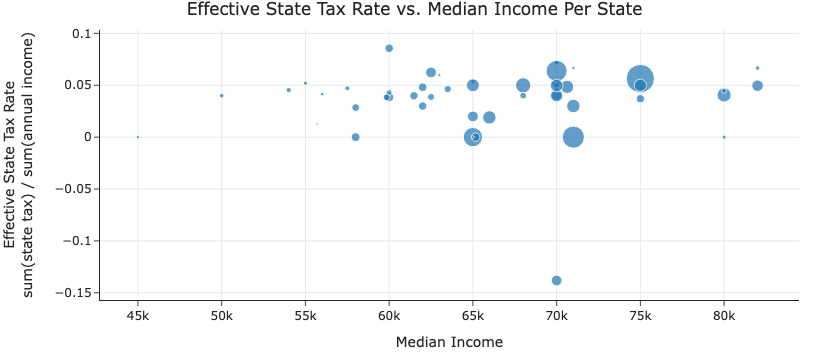

In [315]:
effective_tax_per_state = (
    with_disposable_income
    .groupby('State')
    .apply(lambda df: df['state_tax_owed'].sum() / df['annual_inc'].sum())
)

median_income = (
    with_disposable_income
    .groupby('State')
    ['annual_inc']
    .median()
)

(
    pd.DataFrame()
    .assign(
        effective_tax_per_state=effective_tax_per_state, 
        median_income=median_income,
        count=with_disposable_income.value_counts('State')
    )
    .reset_index()
    .plot(
        kind='scatter',
        x='median_income',
        y='effective_tax_per_state',
        hover_name='State',
        size='count',
        title='Effective State Tax Rate vs. Median Income Per State',
        labels={
            'median_income': 'Median Income',
            'effective_tax_per_state': 'Effective State Tax Rate<br>sum(state tax) / sum(annual income)',
            'count': 'Number of Borrowers'
        }
    )
)

<a name='part3'></a>

## Part 3: Identifying Simpson's Paradox 🙃

([return to the outline](#outline))

In [Lecture 4](https://dsc80.com/resources/lectures/lec04/lec04-filled.html), we introduced the idea of Simpson's Paradox, which occurs when grouped data and ungrouped data show opposing trends. In this final part of the project, we'll try and identify instances of Simpson's Paradox in `loans`.

### Question 9

<a name='Question-9'></a>

([return to the outline](#outline))

Complete the implementation of the function `aggregate_and_combine`. It takes in four arguments:

- `loans`, a DataFrame like `loans`,
- `keywords`, a list of two strings corresponding to keywords to look for in job titles (e.g. `'engineer'`, `'nurse'`, `'teacher'`),
- `quantitative_column`, a string corresponding to a quantitative column in `loans`, and
- `categorical_column`, a string corresponding to a categorical column in `loans`.

It should return a DataFrame that contains the mean value in `quantitative_column` given to those with `keywords[0]` in their job title and `keywords[1]` in their job title, both overall and separately for each group in `categorical_column`.

That's a little cryptic, we know. Let's look at an example to clarify things. For instance, the DataFrame below shows what the output of the following function call should look like:

```py
aggregate_and_combine(loans, ['engineer', 'nurse'], 'loan_amnt', 'home_ownership')
```

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>engineer_mean_loan_amnt</th>
      <th>nurse_mean_loan_amnt</th>
    </tr>
    <tr>
      <th>home_ownership</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>MORTGAGE</th>
      <td>???</td>
      <td>???</td>
    </tr>
    <tr>
      <th>OWN</th>
      <td>???</td>
      <td>???</td>
    </tr>
    <tr>
      <th>RENT</th>
      <td>???</td>
      <td>14358.86</td>
    </tr>
    <tr>
      <th>Overall</th>
      <td>16341.74</td>
      <td>???</td>
    </tr>
  </tbody>
</table>

This DataFrame depicts the mean loan amount given to those with `'engineer'` in their job title and `'nurse'` in their job title, both overall and separately for each home ownership status. We've intentionally hidden most of the values from you, but the two values you do see in the DataFrame match those that you're supposed to produce yourself.

Some things to point out:
- The `'Overall'` row is the last row in the returned DataFrame. **This must also be the case with your implementation of the function.** Note that the `'Overall'` row is **not** simply just the average of the rows above it – think about why this is the case!
- The two column names are `'engineer_mean_loan_amnt'` and `'nurse_mean_loan_amnt'`. We used f-strings to create these: if `keyword` is something like `'nurse'`, then `f'{keyword}_mean_{quantitative_column}'` creates the necessary column names. **Make sure the two columns in your returned DataFrame are formatted exactly this way!**
- You should assume the two keywords in `keywords` are lowercase. Remember, all the way back in Question 1, you cleaned `loans` so that all employment titles in the `'emp_title'` column are lowercase.
- The above table is just an exmaple. You do not need to round to two decimals in your own answer.

***Hint***: You _can_ use a `for`-loop here to avoid repeating yourself. Our solution has a `for`-loop that only runs through two iterations, one for each keyword in `keywords`. On each iteration, it calculates the the relevant information to place in the first $n-1$ rows (per-category means) and last row (overall mean) for that keyword's column.

In [319]:
def aggregate_and_combine(loans, keywords, quantitative_column, categorical_column):
    def col_names(keywords, quantitative_column):
        names = []
        for key in keywords:
            name = f'{key}_mean_{quantitative_column}'
            names.append(name)
        return names
    result = pd.DataFrame(index=np.unique(loans[categorical_column]), columns=col_names(keywords, quantitative_column))
    result.index.name = categorical_column

    unique_cat = np.unique(loans[categorical_column])
    for i in range(len(np.unique(loans[categorical_column]))):
        for j in range(len(keywords)):
            # assign row by row values
            # first is the value in the first column, 
            # second is the value in the second column
            first = loans.loc[(loans['emp_title'].apply(lambda x: keywords[0] in x)) & (loans[categorical_column] == unique_cat[i])][quantitative_column].mean()
            second = loans.loc[(loans['emp_title'].apply(lambda x: keywords[1] in x)) & (loans[categorical_column] == unique_cat[i])][quantitative_column].mean()
            result.iloc[i] = [first, second]
    result = result.dropna(axis = 0, how = 'all')
    mean_1 = loans.loc[loans['emp_title'].apply(lambda x: keywords[0] in x)]['loan_amnt'].mean()
    mean_2 = loans.loc[loans['emp_title'].apply(lambda x: keywords[1] in x)]['loan_amnt'].mean()
    result.loc['Overall'] = [mean_1, mean_2]
    return result

Run the cell below to call `aggregate_and_combine` to find the mean loan amounts given to those with `'engineer'` in their job title and `'nurse'` in their job title, both overall and separately for each home ownership status. Make sure to run this cell before moving forward, otherwise the tests won't work correctly.

In [320]:
eng_nurse_loan_home = aggregate_and_combine(loans, ['engineer', 'nurse'], 'loan_amnt', 'home_ownership')
eng_nurse_loan_home

,engineer_mean_loan_amnt,nurse_mean_loan_amnt
home_ownership,,
MORTGAGE,18007.425743,16374.887892
OWN,19980.693069,19381.661184
RENT,15002.3125,14358.863636
Overall,16341.73588,17461.695447


In [321]:
grader.check("q9")

q9 results: All test cases passed!

Let's look at `eng_nurse_loan_home` once again:

In [322]:
eng_nurse_loan_home

,engineer_mean_loan_amnt,nurse_mean_loan_amnt
home_ownership,,
MORTGAGE,18007.425743,16374.887892
OWN,19980.693069,19381.661184
RENT,15002.3125,14358.863636
Overall,16341.73588,17461.695447


**Pay close attention – if you implemented everything correctly, you should see an instance of Simpson's Paradox above!** Across all three categories of home ownership status – `'MORTGAGE'`, `'OWN'`, and `'RENT'` – those with `'engineer'` in their job title received **higher** loan amounts on average than those with `'nurse'` in their job title. But, the average loan amount given to those with `'engineer'` in their job title was **lower** than the average amount given to those with `'nurse'` in their job title.

### Question 10

<a name='Question-10'></a>

([return to the outline](#outline))

Your task here is two-fold.

#### `exists_paradox`

Complete the implementation of the function `exists_paradox`, which takes in the same arguments as `aggregate_and_combine` and returns `True` if `aggregate_and_combine(loans, keywords, quantitative_column, categorical_column)` contains an instance of Simpson's Paradox and `False` if not.

Note that your implementation should be relatively short. Simpson's Paradox exists when, in the first $n-1$ rows of a DataFrame returned by `aggregate_and_combine`, column A is greater than column B, but in the last row – **which is always the Overall row** – column A is less than column B. This is what we saw with our eyes in `eng_nurse_loan_home`: column A was `'engineer_mean_loan_amnt'` and column B was `'nurse_mean_loan_amnt'`.

**Don't** use a `for`-loop here. In fact, our solution was only two lines long.

<br>

#### `paradox_example`

We've already given one example of arguments that can be passed to `exist_paradox` to return `True`, because we saw an instance of Simpson's Paradox when calling `aggregate_and_combine(loans, ['engineer', 'nurse'], 'loan_amnt', 'home_ownership')`.

Your final task of the project is to **identify another combination of arguments we can pass to `exists_paradox` such that the output is `True`**. Complete the implementation of the function `paradox_example`, which takes in a DataFrame like `loans` and returns a **dictionary** that follows this format:

```py
{
    'loans': loans,
    'keywords': [..., ...],
    'quantitative_column': ...,
    'categorical_column': ...
}
```

If you implemented `exists_paradox` correctly, then `exists_paradox(**paradox_example(loans))` should return `True`. (The `**` allows us to unpack a dictionary into arguments to call a function with – [read this](https://note.nkmk.me/en/python-argument-expand/#:~:text=source%3A%20argument_expand_list_tuple.py-,Expand%20a%20dictionary%20(dict)%20with%20**,-By%20specifying%20a) if you're curious.)

***Note***: You will not receive credit if your `exists_paradox` is the set of arguments we used in Question 9 – that is, you **cannot** use:

```py
{
    'loans': loans,
    'keywords': ['engineer', 'nurse'],
    'quantitative_column': 'loan_amnt',
    'categorical_column': 'home_ownership'
}
```

You also can't just reverse the order of the `'keywords'` key: at least one item (one of the elements in `'keywords'`, `'quantitative_column'`, or `'categorical_column'`) must be different from above.

Remember, Simpson's Paradox occurs when the relationship between two variables reverses or disappears when a dataset is aggregated over a third, "lurking" variable. Your task is to explore potential lurking variables that might reveal Simpson's Paradox when comparing two groups based on job titles (e.g., `'engineer'` vs. `'manager'`).

Initially, test a few combinations manually using the `exists_paradox` function you've created. This should give you a feel for the process. Then, try automating the search. You can do this by iterating over pairs of job titles and categorical variables, using the `exists_paradox` function on each combination.

In [338]:
loans.head()

,id,loan_amnt,issue_d,term,int_rate,grade,sub_grade,emp_title,verification_status,home_ownership,...,loan_status,purpose,desc,addr_state,dti,fico_range_low,fico_range_high,hardship_flag,mths_since_last_delinq,term_end
0,17965023,18000.0,2014-06-01,60,16.99,D,D3,sales,Source Verified,RENT,...,Charged Off,debt_consolidation,NaN,MN,23.22,700.0,704.0,N,72.0,2019-06-01
1,111414087,10000.0,2017-06-01,36,16.02,C,C5,mechanic,Source Verified,OWN,...,Current,home_improvement,NaN,IL,6.14,680.0,684.0,N,6.0,2020-06-01
2,95219557,12800.0,2016-12-01,36,7.99,A,A5,general manager,Not Verified,MORTGAGE,...,Fully Paid,debt_consolidation,NaN,MO,12.89,705.0,709.0,N,66.0,2019-12-01
3,142831837,16000.0,2018-10-01,60,23.40,E,E1,nurse,Source Verified,MORTGAGE,...,Current,home_improvement,NaN,FL,5.66,670.0,674.0,N,NaN,2023-10-01
4,140113255,40000.0,2018-09-01,60,7.84,A,A4,staff pharmacist,Verified,MORTGAGE,...,Current,debt_consolidation,NaN,MN,12.24,735.0,739.0,N,NaN,2023-09-01


In [343]:
def exists_paradox(loans, keywords, quantitative_column, categorical_column):
    df = aggregate_and_combine(loans, keywords, quantitative_column, categorical_column)
    simp1 = df.loc[df.iloc[:, 0] > df.iloc[:, 1]]
    simp1 = len(simp1)
    simp2 = (df.iloc[-1, 0] < df.iloc[-1, 1])
    if (simp1==len(df)-1) & (simp2==True):
         return True
    elif simp1==0 & (not simp2):
        return True
    else:
        return False
    

In [344]:
def paradox_example(loans):
    return {
    'loans': loans,
    'keywords': ['lawyer', 'teacher'],
    'quantitative_column': 'dti',
    'categorical_column': 'addr_state'
    }

If you implemented `exists_paradox` correctly, then `exists_paradox(**paradox_example(loans))` should return `True`. Remember to not just copy the arguments from Question 9.

In [345]:
exists_paradox(**paradox_example(loans))

True

In [346]:
grader.check("q10")

q10 results: All test cases passed!

Congrats! You're done with the project.

The `loans` dataset is rich, and we've just barely scratched the surface in exploring it. We encourage you to keep digging deeper. Just to illustrate what's possible, run the cell below to create a line plot that depcits the number of loans approved per year for each loan purpose (car loan, medical debt, etc.).

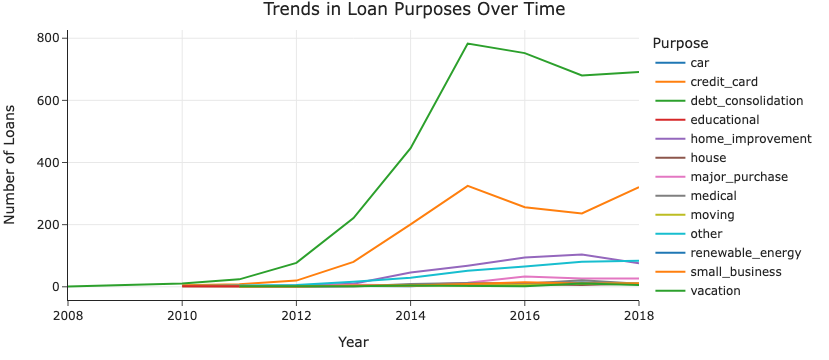

In [347]:
def loan_purpose_over_time(loans):
    loans = loans.copy()
    loan_purpose_yearly = loans.groupby([loans['issue_d'].dt.year, 'purpose']).size().unstack()
    loan_purpose_yearly = loan_purpose_yearly.reset_index().melt(id_vars='issue_d', var_name='Purpose', value_name='Frequency')
    
    fig = px.line(loan_purpose_yearly, x='issue_d', y='Frequency', color='Purpose', title='Trends in Loan Purposes Over Time')
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Number of Loans')
    return fig

loan_purpose_over_time(loans)

## Congratulations, you've finished Project 2! 🎉

As a reminder, all of the work you want to submit needs to be in `project.py`.

To ensure that all of the work you want to submit is in `project.py`, we've included a script named `project-validation.py` in the project folder. You shouldn't edit it, but instead, you should call it from the command line (e.g. the Terminal) to test your work.

Once you've finished the project, you should open the command line and run, in the directory for this project:

```
python project-validation.py
```

**This will run all of the `grader.check` cells that you see in this notebook, but only using the code in `project.py` – that is, it doesn't look at any of the code in this notebook. If all of your `grader.check` cells pass in this notebook but not all of them pass in your command line with the above command, then you likely have code in your notebook that isn't in your `project.py`!**

You can also use `project-validation.py` to test individual questions. For instance,

```
python project-validation.py q1 q4 q7 q8
```

will run the `grader.check` cells for Questions 1, 4, 7, and 8 – again, only using the code in `project.py`.

Once `python project-validation.py` shows that you're passing all test cases, you're ready to submit your `project.py` (and only your `project.py`) to Gradescope. Once submitting to Gradescope, make sure to stick around until all test cases pass.

There is also a call to `grader.check_all()` below in _this_ notebook, but make sure to also follow the steps above.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [348]:
grader.check_all()

q1 results: All test cases passed!

q10 results: All test cases passed!

q2 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q5 results: All test cases passed!

q6 results: All test cases passed!

q7 results: All test cases passed!

q8 results: All test cases passed!

q9 results: All test cases passed!